<a href="https://colab.research.google.com/github/nagolinc/notebooks/blob/main/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#parameters

In [1]:
!wget https://raw.githubusercontent.com/nagolinc/notebooks/main/dog_on_bench.png
!wget https://raw.githubusercontent.com/nagolinc/notebooks/main/dog_on_bench_mask.png

--2022-08-26 14:03:14--  https://raw.githubusercontent.com/nagolinc/notebooks/main/dog_on_bench.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407128 (398K) [image/png]
Saving to: ‘dog_on_bench.png.1’

dog_on_bench.png.1  100%[===================>] 397.59K  --.-KB/s    in 0.005s  

2022-08-26 14:03:14 (81.4 MB/s) - ‘dog_on_bench.png.1’ saved [407128/407128]

--2022-08-26 14:03:14--  https://raw.githubusercontent.com/nagolinc/notebooks/main/dog_on_bench_mask.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886 (12K) [imag

In [40]:
do_inference = False #@param {type:"boolean"}
do_img2img = False #@param {type:"boolean"}
do_inpainting= True #@param {type:"boolean"}
n = 9 #@param {type:"number"}
use_filter = True #@param {type:"boolean"}
prompt = "a cat sitting on a bench" #@param {type:"string"}
save_images = True #@param {type:"boolean"}
init_img_path = "/content/dog_on_bench.png" #@param {type:"string"}
#init_img_path = "E://img//samples//"
mask_img_path = "/content/dog_on_bench_mask.png" #@param {type:"string"}
width = 512 #@param {type:"number"}
height = 512 #@param {type:"number"}
prompt_strength = 0.9 #@param {type:"number"}

#setup


In [41]:
from IPython.display import clear_output 

import os

import glob

In [42]:
sample_path = "./samples"
os.makedirs(sample_path, exist_ok=True)
base_count = max([0]+[int(s[-9:-4]) for s in glob.glob(sample_path+"/*.png")])+1

In [43]:
base_count

2

In [44]:
!nvidia-smi

Fri Aug 26 14:07:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   6416MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next, you should install `diffusers==0.2.4` as well `scipy`, `ftfy` and `transformers`.

In [45]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
#!git clone https://github.com/huggingface/diffusers.git
!git clone https://github.com/nagolinc/diffusers.git

fatal: destination path 'diffusers' already exists and is not an empty directory.


In [47]:
import sys
sys.path.append("/content/diffusers")

from examples.inference.image_to_image import StableDiffusionImg2ImgPipeline, preprocess

You also need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

As google colab has disabled external widgtes, we need to enable it explicitly. Run the following cell to be able to use `notebook_login`

In [48]:
#from google.colab import output
#output.enable_custom_widget_manager()

Now you can login with your user token.

In [49]:
import os
os.makedirs("./AI/StableDiffusion",exist_ok=True)

In [50]:
#hf_token="hf_MyTokenHere"

In [51]:
#from huggingface_hub.commands.user import _login
#from huggingface_hub.hf_api import HfApi, HfFolder
#_login(HfApi(), token=hf_token)

In [52]:
from huggingface_hub import notebook_login
notebook_login()

In [53]:
import torch
from diffusers import StableDiffusionPipeline



In [54]:
def safety_checker(images, clip_input):
  return images, False


In [55]:
from PIL import Image, ImageFilter

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [56]:
from torch import autocast

#Inference

In [57]:
if do_inference:

  # make sure you're logged in with `huggingface-cli login`
  pipe = StableDiffusionPipeline.from_pretrained(
      "CompVis/stable-diffusion-v1-4",
      revision="fp16", 
      torch_dtype=torch.float16, 
      use_auth_token=True,
      cache_dir="./AI/StableDiffusion")  

  if use_filter==False:
    pipe.safety_checker=safety_checker

  pipe = pipe.to("cuda")

In [58]:
if do_inference:
  all_images = []
  for i in range(n):
    with autocast("cuda"):
      images = pipe([prompt],guidance_scale = 7.5,num_inference_steps=20, height=height)["sample"]
      for img in images:
        imgPath=os.path.join(sample_path, "%05d.png"%base_count)
        base_count+=1
        if save_images:
          img.save(imgPath)
        clear_output()
        display(img)
    all_images.extend(images)


#img2img

In [59]:
if do_img2img:

  pipeimg = StableDiffusionImg2ImgPipeline.from_pretrained(
      "CompVis/stable-diffusion-v1-4",
      revision="fp16", 
      torch_dtype=torch.float16,
      use_auth_token=True,
      cache_dir="./AI/StableDiffusion"
  ).to("cuda")

  num_samples = 1

  if use_filter==False:
    pipeimg.safety_checker=safety_checker

  def infer(prompt, init_image,strength=0.75):
    if init_image != None:
        init_image = preprocess(init_image)
        with autocast("cuda"):
            images = pipeimg([prompt] * num_samples, init_image=init_image,strength=strength, guidance_scale=7.5)["sample"]
    else: 
        with autocast("cuda"):
            images = pipe([prompt] * num_samples, strength=strength, guidance_scale=7.5)["sample"]

    return images




In [60]:
if do_img2img:
  for i in range(n):
    init_img=Image.open(init_img_path).convert('RGB')
    imgOut=infer(prompt,init_img,prompt_strength)
    imgPath=os.path.join(sample_path, "%05d.png"%base_count)
    base_count+=1
    if save_images:
      imgOut[0].save(imgPath)
    clear_output()
    display(imgOut[0])

#Inpainting

In [61]:
from examples.inference.inpainting import StableDiffusionInpaintingPipeline

In [62]:
if do_inpainting:

  pipeimg = StableDiffusionInpaintingPipeline.from_pretrained(
      "CompVis/stable-diffusion-v1-4",
      revision="fp16", 
      torch_dtype=torch.float16,
      use_auth_token=True,
      cache_dir="./AI/StableDiffusion"
  ).to("cuda")

  num_samples = 1

  if use_filter==False:
    pipeimg.safety_checker=safety_checker



In [63]:
if do_inpainting:
  def infer(prompt, init_image, mask_image, strength=0.75):
    if init_image != None:
        mask_blur=mask_image.filter(ImageFilter.GaussianBlur(radius = 8))
        with autocast("cuda"):
            images = pipeimg([prompt] * num_samples, 
                             init_image=init_image,
                             mask_image=mask_image,
                             strength=strength, 
                             num_inference_steps=200,
                             guidance_scale=7.5)["sample"]
            images= [Image.composite(image,init_image,mask_blur) for image in images]
    else: 
        with autocast("cuda"):
            images = pipe([prompt] * num_samples, strength=strength, guidance_scale=7.5)["sample"]

    return images

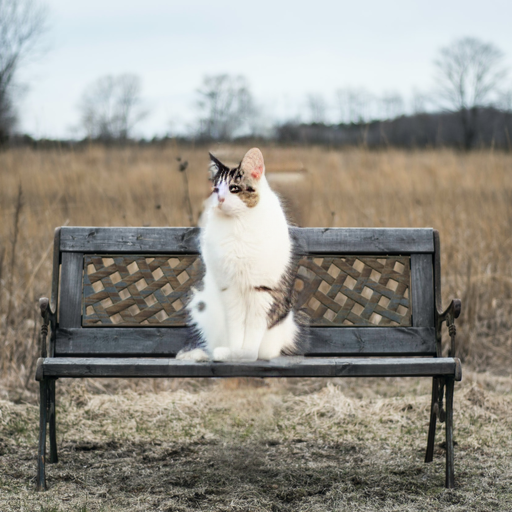

0it [00:00, ?it/s]

KeyboardInterrupt: ignored

In [64]:
if do_inpainting:
  init_img=Image.open(init_img_path).convert('RGB')
  mask_img=Image.open(mask_img_path).convert('L')
  for i in range(n):
    
    imgOut=infer(prompt,init_img,mask_img,prompt_strength)
    imgPath=os.path.join(sample_path, "%05d.png"%base_count)
    base_count+=1
    if save_images:
      imgOut[0].save(imgPath)
    clear_output()
    display(imgOut[0])